### Import libraries

In [1]:
import sys
sys.path.append("..")
import os
from model import experimental_model, experimental2d_model, grapher
from data import batch_creator, loader, data_generation
from helpers import helpers, plotter, metrics
import tensorflow as tf
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import itertools

In [3]:
kernel = "monthly_global_avg_climate"
d = True

In [4]:
mpi = np.load('/Users/omernivron/Downloads/MPI_ESM_monthly_global_mean.npy')
gfdl = np.load('/Users/omernivron/Downloads/GFDL_monthly_global_mean.npy')

In [5]:
t = np.load('/Users/omernivron/Downloads/monthly_t.npy')

In [6]:
save_dir = os.path.expanduser('~/Downloads/' + kernel)

In [7]:
mpi

array([[276.39157104, 276.72406006, 277.17687988, ..., 279.72692871,
        278.58798218, 278.44827271],
       [277.11743164, 276.59268188, 276.32434082, ..., 279.90072632,
        278.94741821, 278.17526245],
       [277.48260498, 276.92874146, 277.60958862, ..., 279.41195679,
        278.12228394, 277.92831421],
       ...,
       [276.50933838, 276.35671997, 276.21139526, ..., 279.61593628,
        278.97723389, 278.42648315],
       [276.48617554, 276.18310547, 276.62106323, ..., 279.85339355,
        278.89978027, 278.03179932],
       [276.61984253, 276.70706177, 276.47772217, ..., 279.56781006,
        278.60501099, 278.31607056]])

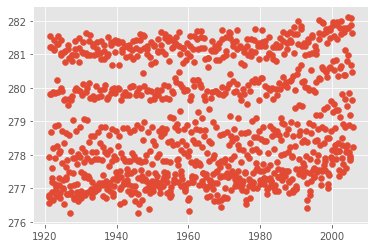

In [8]:
plt.scatter(t, mpi[17])

In [9]:
data = np.concatenate((mpi, gfdl), axis = 0)
μ = np.mean(data)
σ = np.std(data)
mpi = (mpi - μ) 
gfdl = (gfdl - μ) 

In [10]:
n = mpi.shape[0]
m = gfdl.shape[0]
seq_len = 1020

In [11]:
combos = list(itertools.combinations(np.arange(n), 2)) + [(i, i) for i in range(n)]
data = [np.concatenate((mpi[pair[0]].reshape(1, -1), gfdl[pair[1]].reshape(1, -1)), axis = 1) if (pair[1] < 30) else np.zeros((1, 2040)) for pair in combos]

In [12]:
df = np.concatenate(data, axis=0)

In [13]:
y = df[~np.all(df == 0, axis=1)]

In [14]:
t = np.concatenate((t, t))
t = t - np.mean(t)

In [15]:
t[:10]

array([-42.45833333, -42.375     , -42.29166667, -42.20833333,
       -42.125     , -42.04166667, -41.95833333, -41.875     ,
       -41.79166667, -41.70833333])

In [16]:
d_y = np.array([np.concatenate((y[i][j:j+205], y[i][1020+j:1225 +j])) for i in range(len(y)) for j in range(0, 815, 163) ])
t_y = np.array([np.concatenate((t[j:j+205], t[1020+j:1225 +j])) for i in range(len(y)) for j in range(0, 815, 163)])

In [17]:
t_y[0, :]

array([-42.45833333, -42.375     , -42.29166667, -42.20833333,
       -42.125     , -42.04166667, -41.95833333, -41.875     ,
       -41.79166667, -41.70833333, -41.625     , -41.54166667,
       -41.45833333, -41.375     , -41.29166667, -41.20833333,
       -41.125     , -41.04166667, -40.95833333, -40.875     ,
       -40.79166667, -40.70833333, -40.625     , -40.54166667,
       -40.45833333, -40.375     , -40.29166667, -40.20833333,
       -40.125     , -40.04166667, -39.95833333, -39.875     ,
       -39.79166667, -39.70833333, -39.625     , -39.54166667,
       -39.45833333, -39.375     , -39.29166667, -39.20833333,
       -39.125     , -39.04166667, -38.95833333, -38.875     ,
       -38.79166667, -38.70833333, -38.625     , -38.54166667,
       -38.45833333, -38.375     , -38.29166667, -38.20833333,
       -38.125     , -38.04166667, -37.95833333, -37.875     ,
       -37.79166667, -37.70833333, -37.625     , -37.54166667,
       -37.45833333, -37.375     , -37.29166667, -37.20

In [18]:
TΔmin = 0.05; Tmax = 30

In [19]:
d =80

In [20]:
    R = Tmax / TΔmin * 100
    drange_even = TΔmin * R**(np.arange(0,d,2)/d)
    drange_odd = TΔmin * R**((np.arange(1,d,2) - 1)/d)



In [21]:
 1/ drange_even[:20]

array([20.        , 15.190645  , 11.53778477,  8.76331962,  6.65602387,
        5.05546478,  3.83978854,  2.91644323,  2.21513269,  1.68246471,
        1.27788621,  0.97059579,  0.7371988 ,  0.55992626,  0.42528206,
        0.32301544,  0.24534064,  0.18634413,  0.14153438,  0.10749992])

In [22]:
def embed_position(t, d, TΔmin, Tmax):  # return.shape=(T,B,d)
    # t.shape=(T,B)   T=sequence_length, B=batch_size
    """A position-embedder, similar to the Attention paper, but tweaked to account for
    floating point positions, rather than integer.
    """
    R = Tmax / TΔmin * 100
    drange_even = TΔmin * R**(np.arange(0,d,2)/d)
    drange_odd = TΔmin * R**((np.arange(1,d,2) - 1)/d)
    x = np.concatenate([np.sin(t[:,:,None] / drange_even), np.cos(t[:,:,None] / drange_odd)], 2)
    return x

In [23]:
k = np.concatenate([np.zeros(205, dtype=int), np.ones(205, dtype=int)])

In [24]:
x1 = np.array([embed_position(t_y[i, :][:, None], d=80, TΔmin= 0.05, Tmax=30) for i in range(len(t_y))])
x2 = np.repeat(tf.one_hot(k, 2)[None, :, None, :],  2325, axis =0)
x = np.concatenate((x1, x2), axis =-1).squeeze()

In [26]:
x.shape

(2325, 410, 82)

(array([ 23179., 130290.,  80944., 101690., 148683., 127678., 133126.,
         86823.,  75603.,  45234.]),
 array([-4.36111828, -3.50394055, -2.64676281, -1.78958508, -0.93240734,
        -0.07522961,  0.78194812,  1.63912586,  2.49630359,  3.35348133,
         4.21065906]),
 <a list of 10 Patch objects>)

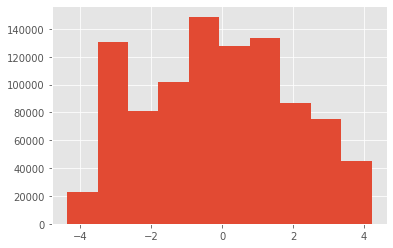

In [36]:
plt.hist(d_y.reshape(-1))

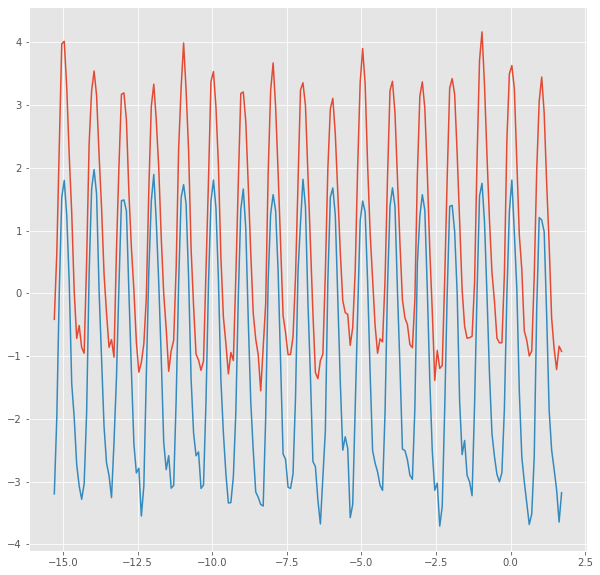

In [31]:
cmap = plt.get_cmap('Paired', 2)

fig,ax = plt.subplots(figsize=(10, 10))
ax.plot(t_y[17, :205], d_y[17][:205])
ax.plot(t_y[17, 205:], d_y[17][205:])
plt.show()

In [259]:
train_step, test_step, train_loss, test_loss, m_tr, m_te = grapher.build_graph()

In [231]:
# b_data = batch_creator.create_batch(em_x = data[1], em_y=data[3], x = data[5], y = data[-1], batch_s=2, d=d)
# b_data_te = b_data

In [232]:
# Uncomment the two lines below for one batch to overfit on
# np.random.seed(443)
# b_data, c = batch_creator.create_batch_2d(data[2], data[-3], data[-1], batch_s=20, em_2 = data[3])

### Training

Does not exist
New folder /Users/omernivron/Downloads/monthly_global_avg_climate/ckpt/check_run_1
Initializing from scratch.
2168


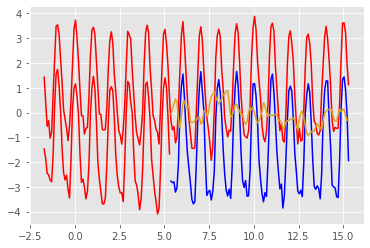

Epoch 0 batch 0 train Loss 0.9667 test Loss 0.8991 with training MSE metric 5.1119 and testing MSE metric 4.6802
learning rate is 0.0003000000142492354
2324


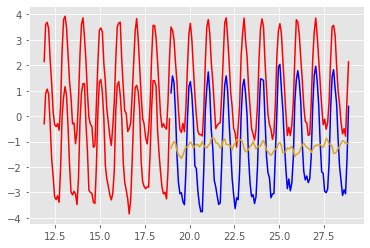

Epoch 0 batch 50 train Loss 0.7289 test Loss 0.7233 with training MSE metric 3.3362 and testing MSE metric 3.2742
learning rate is 0.0003000000142492354
Time taken for 1 epoch: 64.32133984565735 secs

2235


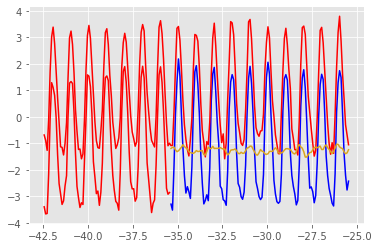

Epoch 1 batch 0 train Loss 0.7243 test Loss 0.7179 with training MSE metric 3.3107 and testing MSE metric 3.2544
learning rate is 0.0003000000142492354
2008


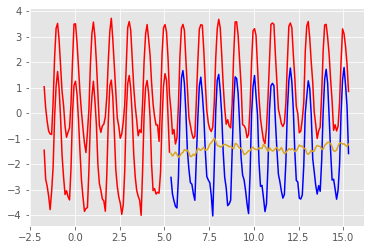

Epoch 1 batch 50 train Loss 0.7121 test Loss 0.7089 with training MSE metric 3.1779 and testing MSE metric 3.1626
learning rate is 0.0003000000142492354
Time taken for 1 epoch: 63.02314114570618 secs

2138


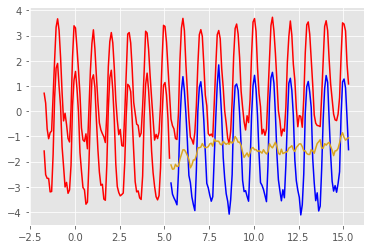

Epoch 2 batch 0 train Loss 0.6911 test Loss 0.6635 with training MSE metric 2.9819 and testing MSE metric 2.7597
learning rate is 0.0003000000142492354
2301


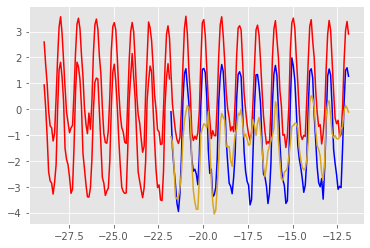

Epoch 2 batch 50 train Loss 0.4371 test Loss 0.3975 with training MSE metric 1.4001 and testing MSE metric 1.3209
learning rate is 0.0003000000142492354
Time taken for 1 epoch: 70.28725290298462 secs

2114


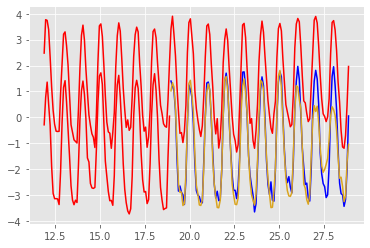

Epoch 3 batch 0 train Loss 0.1872 test Loss 0.0876 with training MSE metric 0.5137 and testing MSE metric 0.3603
learning rate is 0.0003000000142492354
2073


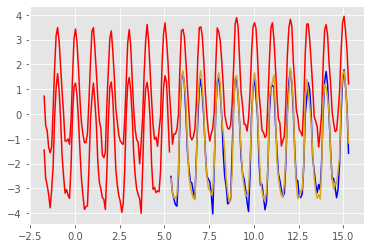

Epoch 3 batch 50 train Loss 0.0435 test Loss -0.0615 with training MSE metric 0.2773 and testing MSE metric 0.1608
learning rate is 0.0003000000142492354
Time taken for 1 epoch: 67.83955979347229 secs

2119


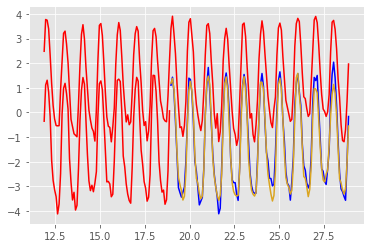

Epoch 4 batch 0 train Loss 0.0067 test Loss -0.1413 with training MSE metric 0.2168 and testing MSE metric 0.1017
learning rate is 0.0003000000142492354
2221


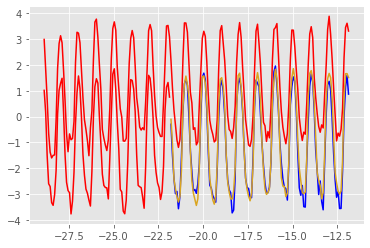

Epoch 4 batch 50 train Loss -0.0598 test Loss -0.1721 with training MSE metric 0.1611 and testing MSE metric 0.0870
learning rate is 0.0003000000142492354
Time taken for 1 epoch: 67.19318199157715 secs

2100


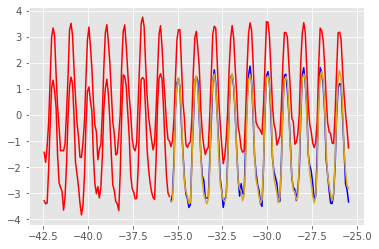

Epoch 5 batch 0 train Loss -0.0992 test Loss -0.1904 with training MSE metric 0.1308 and testing MSE metric 0.0846
learning rate is 0.0003000000142492354
2321


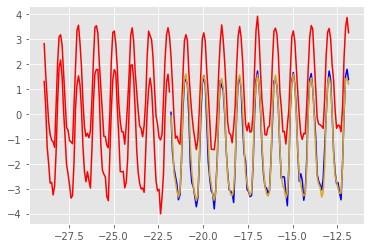

Epoch 5 batch 50 train Loss -0.1296 test Loss -0.2020 with training MSE metric 0.1146 and testing MSE metric 0.0810
learning rate is 0.0003000000142492354
Time taken for 1 epoch: 70.49486017227173 secs

2170


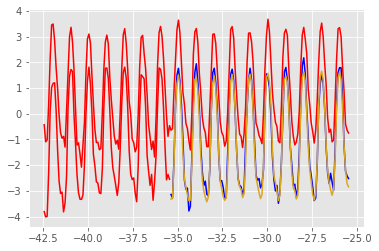

Epoch 6 batch 0 train Loss -0.1563 test Loss -0.2328 with training MSE metric 0.1012 and testing MSE metric 0.0686
learning rate is 0.0003000000142492354
2159


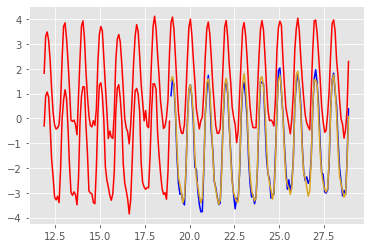

Epoch 6 batch 50 train Loss -0.1150 test Loss -0.2284 with training MSE metric 0.1215 and testing MSE metric 0.0712
learning rate is 0.0003000000142492354
Time taken for 1 epoch: 67.47407698631287 secs

2125


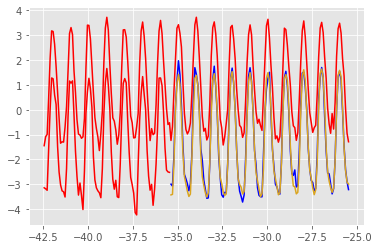

Epoch 7 batch 0 train Loss -0.1593 test Loss -0.2432 with training MSE metric 0.0976 and testing MSE metric 0.0661
learning rate is 0.0003000000142492354
2215


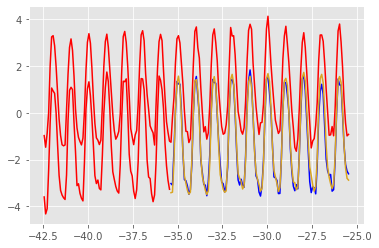

Epoch 7 batch 50 train Loss -0.1853 test Loss -0.2638 with training MSE metric 0.0891 and testing MSE metric 0.0608
learning rate is 0.0003000000142492354
Time taken for 1 epoch: 62.99159026145935 secs

2056


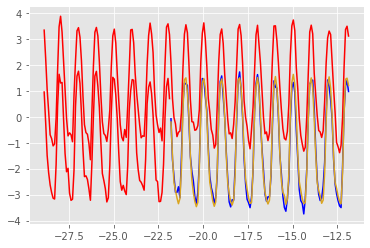

Epoch 8 batch 0 train Loss -0.1904 test Loss -0.2545 with training MSE metric 0.0881 and testing MSE metric 0.0645
learning rate is 0.0003000000142492354
2318


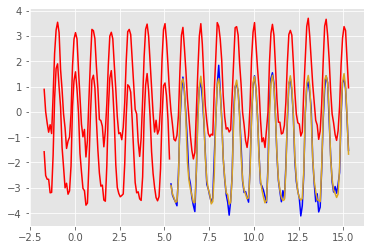

Epoch 8 batch 50 train Loss -0.1927 test Loss -0.2394 with training MSE metric 0.0875 and testing MSE metric 0.0707
learning rate is 0.0003000000142492354


KeyboardInterrupt: 

In [233]:
if __name__ == '__main__':
    step = 0
    # change to run 9 if you want to overfit
    EPOCHS = 575; batch_s  = 32; run = 1; tr_regime ='shuffle'
    l= [82, 64, 32]; heads = 32; e = 82; context = 290; c=290
    decoder, optimizer_c, ckpt, manager, num_batches, writer, folder = helpers.pre_trained_loader(data[3], save_dir, e, l, d=d, batch_s=64, context=context, heads=1, run=run)
    with writer.as_default():
        for epoch in range(EPOCHS):
            start = time.time()
            for batch_n in range(100):
                m_tr.reset_states(); train_loss.reset_states()
                if d:
                    idxs = np.random.choice(np.arange(2000), 32)
                    permute_idx = np.arange(410)
                    y_tr = d_y[idxs, :][:, permute_idx] 
                    x_tr = x[idxs, :]
                    to_gather = helpers.gather_idx(c,  l=410, b=32)
                    temp = np.zeros((32, 410))
                    temp[to_gather[:, 0], to_gather[:, 1]] = 1
#                   b_data, c = batch_creator.batch_regime_2d(x = data[-3], y = data[-1], em = data[2] , em_2 =  data[3], batch_s=64, context_p=50, kind='shuffle')
                    # add parameter b=20 to helpers.gather_idx if you want to overfit and comment line above
                    pred, pred_log, weights, names, shapes, y_real, g = train_step(decoder, optimizer_c, train_loss, m_tr, x_tr, y_tr, d = True, to_gather=temp)
                else:
#                     b_data = batch_creator.create_batch(em_x = data[1], x = data[3], y = data[-1], batch_s=64, d=d)
                    to_gather = helpers.gather_idx(context, l=200, b=2)
                    temp = np.zeros((b_data[0].shape[0], b_data[0].shape[1]))
                    temp[to_gather[:, 0], to_gather[:, 1]] = 1
                    pred, pred_log, weights, names, shapes, y_real, g = train_step(decoder, optimizer_c, train_loss, m_tr, x = b_data[2], y = b_data[0], y2=b_data[3], to_gather = temp)
                if (epoch == 0) & (batch_n == 0): helpers.write_speci(folder, names, shapes, context, heads)
                if batch_n % 50 == 0:
                    m_te.reset_states(); test_loss.reset_states()
                    if d:
                        idxs_te = np.random.choice(np.arange(2000, 2325), 32)
                        print(idxs_te[1])
                        permute_idx_te = np.arange(410)
                        to_gather_te = helpers.gather_idx(c, l=410, b=32)
                        temp_te = np.zeros((32, 410))
                        temp_te[to_gather_te[:, 0], to_gather_te[:, 1]] = 1
                        y_te = d_y[idxs_te, :][:, permute_idx_te] 
                        x_te = x[idxs_te, :]
                        pred_te, pred_log_te = test_step(decoder, test_loss, m_te, x_te = x_te, y_te = y_te, to_gather=temp_te, d=True)
                        fig,ax = plt.subplots()
                        
                        ax.plot(t_y[idxs_te[1], 290:], y_te[1][290:], c='blue')
                        ax.plot(t_y[idxs_te[1], :205], y_te[1][:205], c='red')
                        ax.plot(t_y[idxs_te[1], 205:290], y_te[1][205:290], c='red')
                        ax.plot(t_y[idxs_te[1], 290:], pred_te[1, 289:], c='goldenrod') 
                        plt.show()
                        
                        
                        
#                         b_data_te, c_te = batch_creator.batch_regime_2d(x = data[-4], y = data[-2], em = data[0] , em_2 =  data[1], batch_s=64, context_p=context, kind=tr_regime)
#                         to_gather_te = helpers.gather_idx(c_te)
#                         temp_te = np.zeros((b_data_te[0].shape[0], b_data_te[0].shape[1]))
#                         temp_te[to_gather_te[:, 0], to_gather_te[:, 1]] = 1
#                         pred_te, pred_log_te = test_step(decoder, test_loss, m_te, x_te = b_data_te[2], y_te = b_data_te[0], x2_te = b_data_te[3], to_gather=temp_te, d=True)
#                         ## Plotting progress by looking at a random test case. Erase _te from the six lines below if you rather observe training

#                         if to_gather_te is not None:
#                             # change 64 to 20 if you are overfitting
#                             idd = np.random.choice(np.arange(0, 64))
#                             seq_l = to_gather_te[to_gather_te[:, 0] == idd][0, 1]
#                             plt.scatter(b_data_te[1][idd, :seq_l], b_data_te[0][idd, :seq_l] , c = 'blue', label = 'context')
#                             plt.scatter(b_data_te[1][idd, seq_l:], b_data_te[0][idd, seq_l:], c = 'black', label = 'observed func.', alpha=0.5)
#                             plt.scatter(b_data_te[1][idd, seq_l:], pred_te[idd][(seq_l - 1):], label = 'predicted func.')
#                             plt.legend()
#                             plt.show()
#                         else:
#                             plotter.follow_training_plot2d(x_tr = b_data[1], y_tr = b_data[0], em_2_tr = b_data[3] , pred = pred, x_te = b_data_te[2], y_te = b_data_te[0], em_2_te = b_data_te[3] ,pred_te = pred_te, num_context = context)
                    else:
                        pred_te, pred_log_te = test_step(decoder, test_loss, m_te, x_te = b_data_te[2], y_te = b_data_te[0], y2_te=b_data_te[3], to_gather = temp)
                        plotter.follow_training_plot(x_tr = b_data[1], y_tr = b_data[0], pred = pred, x_te = b_data_te[2], y_te = b_data_te[0], pred_te = pred_te, num_context = context)
                    helpers.print_progress(epoch, batch_n, train_loss.result(), test_loss.result(), m_tr.result(), m_te.result())
                    helpers.tf_summaries(run, step, train_loss.result(), test_loss.result(), m_tr.result(), m_te.result(), weights, names)
                    print('learning rate is {}'.format(optimizer_c._decayed_lr('float32').numpy()))
#                     if d:
#                         m0, m1 = metrics.r_sq_2d(b_data[0][:, 1:], pred.numpy(), b_data[3][:, 1:], context_p = context)
#                         m0_te, m1_te = metrics.r_sq_2d(b_data_te[0][:, 1:], pred_te.numpy(), b_data_te[3][:, 1:], context_p = context)
#                         print('r squared training, series 0: {}, series 1: {}'.format(m0, m1))
#                         print('r squared testing, series 0: {}, series 1: {}'.format(m0_te, m1_te))
                    manager.save()
                step += 1
                ckpt.step.assign_add(1)
            print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

In [139]:
pred_te.shape

TensorShape([32, 409])

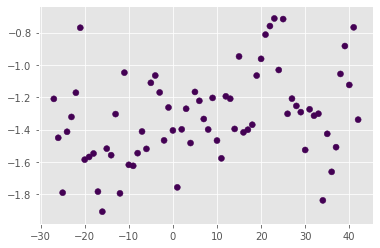

In [299]:
plt.scatter(t[100:], pred_te[1, 99:], c=k[100:]) 

### Embeddings in tensorboard

In [ ]:
helpers.tensorboard_embeddings(decoder, layer_num = 0, meta_data = np.concatenate(([0, 1], np.unique(b_data[2]))))

### Inference

In [39]:
d_y[1, :290].shape

(290,)

In [258]:
x.shape

(2325, 410, 82)

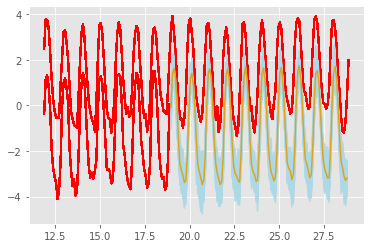

In [272]:
idd = np.random.choice(np.arange(325))
fig,ax = plt.subplots()
for j in range(100):
    y_s = d_y[2000 + idd, :290] 
    y_s = y_s[:-1][None, :]
    for i in range(119):
        x_s = x[2000+idd, :(290 + i), :][None, :, :]
        _, _, sample_y = evaluate(decoder, x_s, y_s, d=d, sample=True)
        y_s = tf.concat((y_s, tf.reshape(sample_y, [1, 1])), axis=1)
    ax.plot(t_y[2000+idd, :205], d_y[2000+idd][:205], c='red')
    ax.plot(t_y[2000+idd, 205:290], d_y[2000+idd][205:290], c='red')
    
    ax.plot(t_y[2000+idd, 290:-1], (y_s.numpy()[:, 289:].reshape(-1)), c='lightblue')
y_s = d_y[2000 + idd, :290] 
y_s = y_s[:-1][None, :]
for i in range(119):
    x_s = x[2000+idd, :(290 + i), :][None, :, :]
    _, _, sample_y = evaluate(decoder, x_s, y_s, d=d, sample=False)
    y_s = tf.concat((y_s, tf.reshape(sample_y, [1, 1])), axis=1)
ax.plot(t_y[2000+idd, :205], d_y[2000+idd][:205], c='red')
ax.plot(t_y[2000+idd, 205:290], d_y[2000+idd][205:290], c='red')
ax.plot(t_y[2000+idd, 290:-1], (y_s.numpy()[:, 289:].reshape(-1)), c='goldenrod')
ax.plot(t_y[2000+idd, 290:], d_y[2000+idd][290:], c='blue')

In [263]:
def evaluate(model, x, y, sample=True, d=False):

    combined_mask_x = masks.create_masks(x[:, :, 0])
    pred = model(x, y, False, combined_mask_x[:, :-1, :-1])
    if sample:
        sample_y = np.random.normal(pred[-1, 0], np.exp(pred[-1, 1]))
    else:
        sample_y = pred[-1, 0]

    return pred[:, 0], pred[:, 1], sample_y

In [264]:
from helpers import masks